#Paquetes necesarios

In [31]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Carga imagen y convierte a RGB

(938, 473, 3)


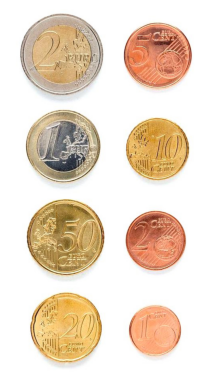

In [32]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

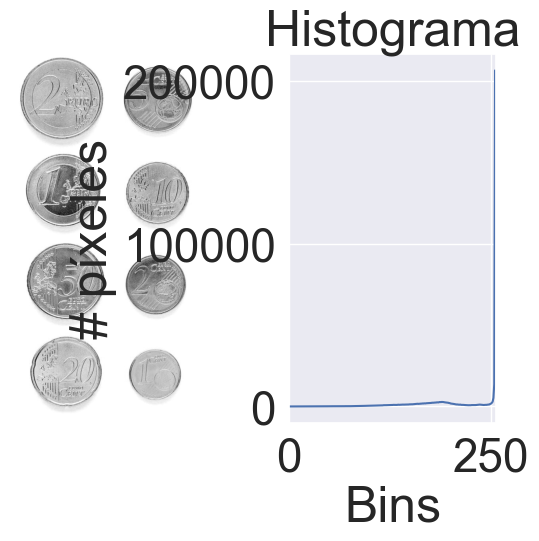

In [33]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Cuenta elementos tras umbralizar

Umbral fijo usado  200.0
Umbral Otsu  204.0


Text(0.5, 1.0, 'OTSU invertida')

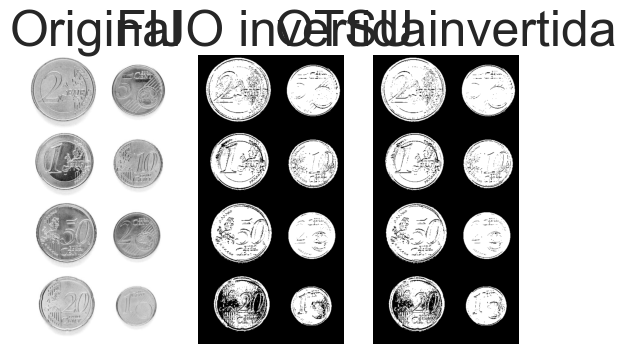

In [34]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


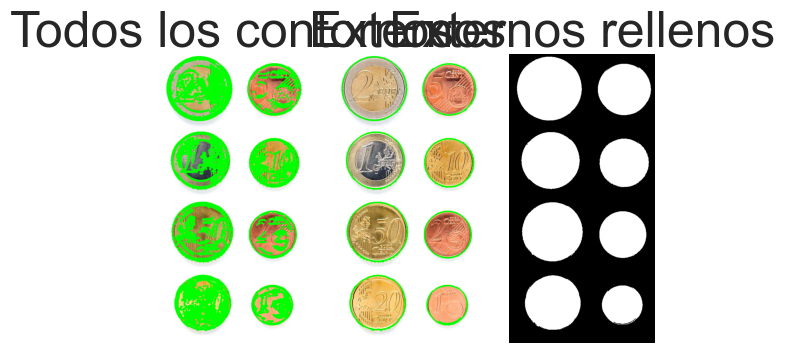

In [35]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)

#Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

#Dibuja sobre la imagen de entrada los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos puede interesará mostrar los valores obtenidos del contorno
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Alternativa contando círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


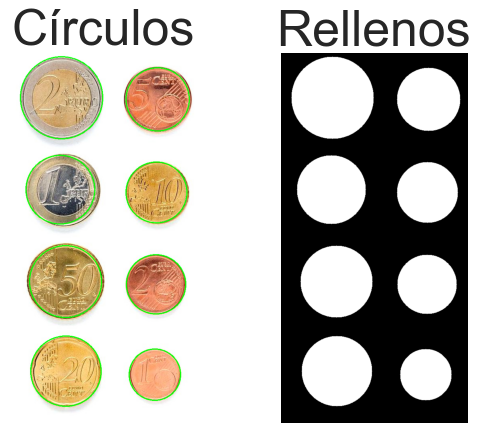

In [36]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la corespondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



Clicked at: (100, 213)
Scale set to 0.21 pixels per mm
Average color in HSV: [ 16.76121401  80.78654318 202.27995983]
Identified coin of unknown at (82, 206) with radius 55


El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

Umbral escogido  197.0


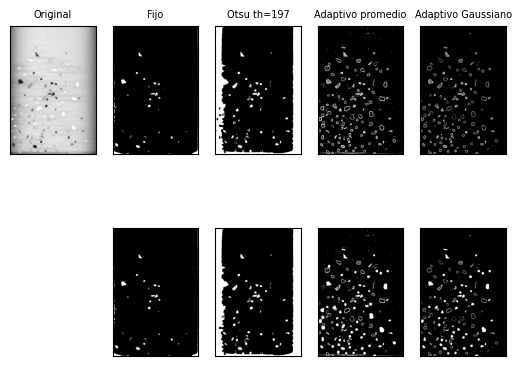

In [20]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Clasificación de microplásticos

Text(0.5, 1.0, 'Alquitrán')

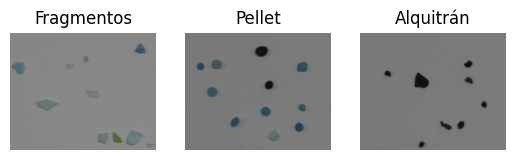

In [21]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas desde características geométricas y/o de apariencia, para distinguir en las imágenes completas, las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [1, 3, 3, 3, 2, 2, 0, 1, 3, 2, 3, 3, 3, 1, 3, 3, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 2, 3, 1, 2, 2, 3, 3, 3, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3, 0, 1, 2, 1, 0, 3, 0, 1, 2, 2, 3, 2, 1, 1, 2, 1, 0, 3, 3, 3, 1, 0, 3, 3, 0, 0, 3, 0, 2, 3, 2, 2, 3, 1, 2, 0, 2, 3, 0, 3, 3, 2, 0, 3, 0, 2]
Predicciones  [0, 0, 3, 0, 0, 2, 2, 3, 0, 3, 2, 0, 0, 2, 2, 2, 1, 3, 2, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 3, 3, 1, 3, 0, 2, 1, 0, 1, 1, 0, 2, 0, 3, 3, 3, 0, 2, 0, 3, 0, 0, 3, 2, 0, 3, 2, 3, 2, 1, 3, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 3, 1, 2, 1, 0, 3, 1, 3, 0, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 0]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.21
Precision (TP/(TP+FP)) = 0.21390425666287738
Recall (TP/(TP+FN)) = 0.21
F1 Score (2*(precision*recall)/(precision+recall)) = 0.2100946303456697


Text(38.25, 0.5, 'Real/Anotado')

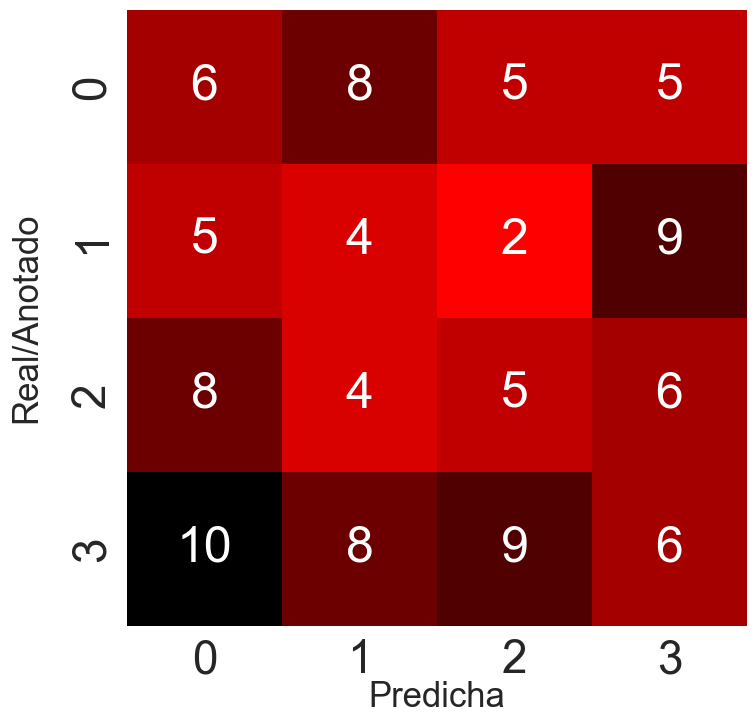

In [22]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

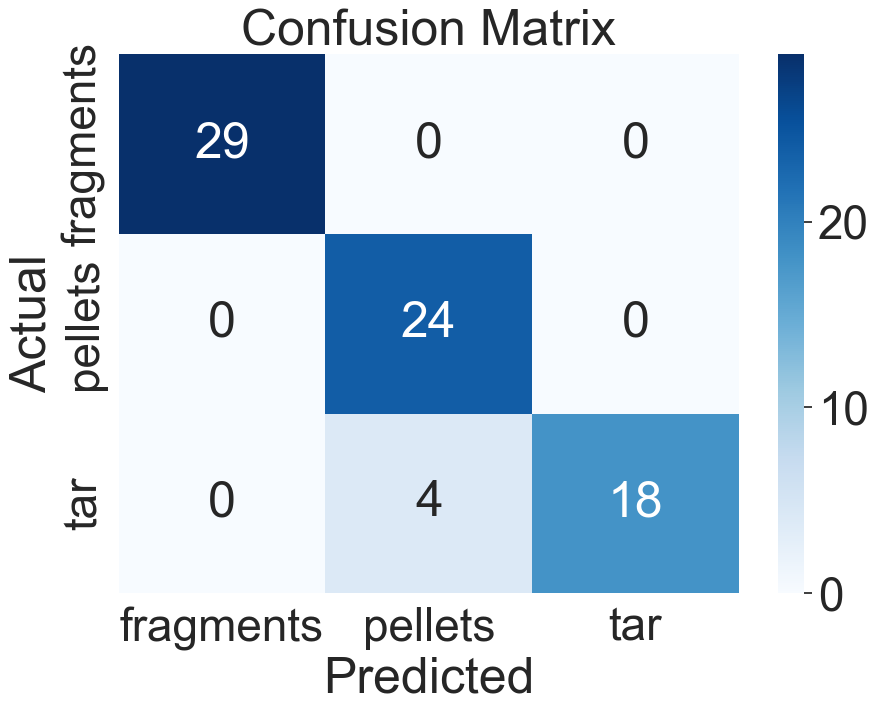

              precision    recall  f1-score   support

   fragments       1.00      1.00      1.00        29
     pellets       0.86      1.00      0.92        24
         tar       1.00      0.82      0.90        22

    accuracy                           0.95        75
   macro avg       0.95      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75



In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar imágenes sin redimensionar
images = {
    'fragments': cv2.imread('FRA.png'),
    'pellets': cv2.imread('PEL.png'),
    'tar': cv2.imread('TAR.png')
}

# Función de preprocesamiento
def preprocess_image(image):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar desenfoque gaussiano
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Aplicar umbral binario inverso con el método Otsu
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

# Función de extracción de características con reducción de histogramas
def extract_features(contour, gray_image):
    # Calcular el área y el perímetro del contorno
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    # Calcular la compacidad
    compactness = (perimeter ** 2) / area if area != 0 else 0
    # Obtener el rectángulo delimitador y su relación de aspecto
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    # Ajustar el contorno a una elipse si es posible
    ellipse = cv2.fitEllipse(contour) if len(contour) >= 5 else None
    major_axis = max(ellipse[1]) if ellipse else 0
    minor_axis = min(ellipse[1]) if ellipse else 0
    axis_ratio = major_axis / minor_axis if minor_axis != 0 else 0
    # Calcular la convexidad y solidez
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    
    # Características de textura usando OpenCV con reducción de bins
    mask = np.zeros(gray_image.shape, dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
    hist = cv2.calcHist([masked], [0], mask, [32], [0, 256])  # Histograma con 32 bins
    hist = cv2.normalize(hist, hist).flatten()  # Normalizar el histograma
    
    return [area, perimeter, compactness, aspect_ratio, axis_ratio, solidity] + hist.tolist()

# Funciones de aumento de datos utilizando OpenCV
def horizontal_flip(image):
    # Invertir horizontalmente la imagen
    return cv2.flip(image, 1)

def rotate_image(image, angle):
    # Rotar la imagen según el ángulo dado
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def adjust_brightness(image, factor):
    # Ajustar el brillo de la imagen
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def gaussian_blur(image, kernel_size):
    # Aplicar desenfoque gaussiano
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Procesar cada imagen y extraer características en paralelo
def process_image(label, image):
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar preprocesamiento
    thresh = preprocess_image(image)
    # Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    data = []
    labels = []
    # Extraer características de cada contorno
    for contour in contours:
        if cv2.contourArea(contour) > 5:  # Umbral para contornos pequeños
            features = extract_features(contour, gray_image)
            data.append(features)
            labels.append(label)
    return data, labels

# Aumentar las imágenes y procesarlas
augmented_results = []
for label, image in images.items():
    # Aplicar aumentos a cada imagen
    augmented_images = [
        image,
        horizontal_flip(image),
        rotate_image(image, 15),
        rotate_image(image, -15),
        adjust_brightness(image, 1.2),
        adjust_brightness(image, 0.8),
        gaussian_blur(image, 5)
    ]
    for aug_image in augmented_images:
        augmented_results.append(process_image(label, aug_image))

# Unificar los resultados en una sola lista
data = [item for sublist in augmented_results for item in sublist[0]]
labels = [item for sublist in augmented_results for item in sublist[1]]

# Convertir los datos en un DataFrame
columns = ['Area', 'Perimeter', 'Compactness', 'Aspect_Ratio', 'Axis_Ratio', 'Solidity'] + [f'Hist_{i}' for i in range(32)]
df = pd.DataFrame(data, columns=columns)
df['Label'] = labels

# Dividir los datos en entrenamiento y prueba
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el clasificador RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predecir y evaluar
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el informe de clasificación
print(report)
